## Import Libraries


/pfs/data5/home/kit/stud/updzl/Experiment 1
/pfs/data5/home/kit/stud/updzl/Experiment 1


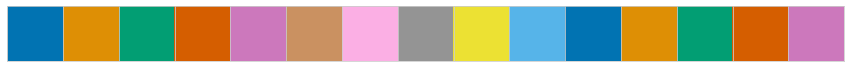

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import torch
#from google.colab import drive
import os
import torch
from torch import nn, optim
from torch.optim import Adam
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
#!pip install torch pytorch-lightning
#import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
from torch.utils.data import TensorDataset, DataLoader
#import torchvision
#from torch.utils.tensorboard import SummaryWriter
import datetime
import csv
import time
import random
###
# Ralf Loritz 15.2.2022
# Rainfall-runoff using LSTM Models
# Pytorch
###
#%load_ext autoreload
#%autoreload 2 #Reload all modules every time before executing the Python code typed.

# built-in
import os
import importlib
import math
import collections
###
# addtional packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# set torch seed
def setup_seed(seed):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  

seed=28
setup_seed(seed)

# import from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

# import own loss functions
#from src.loss_functions import kge, kgeprime, nse, rmse
#from src.ML_functions import onehot_encode_pd, lagged_features, get_scaler
#from src.ML_train import train_model

#-----------------------
#import src.ML_train
#importlib.reload(src.ML_train)
#from src.ML_train import train_model
#----------------------


###
# set plot style seaborn
sns.set_style("whitegrid")

# set colors
current_palette = sns.color_palette("colorblind", 15)
sns.palplot(current_palette)
print(os.getcwd())
# set workspcae
os.chdir('./')
print(os.getcwd())

In [2]:
#drive.mount('/content/drive')

###
# identify GPU
#print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')

## Functions & Objects


In [3]:
# Preprocessing etc.


# Creates a training, validation and test data set
# Check https://onlinelibrary.wiley.com/doi/abs/10.1029/2021WR031523 for split sampling approaches in hydrological modeling
# Validation period is usually very small and is used to check the performance of the model during the training on a out-of-sample batch
# to monitor evtl. overfitting
def split_data(start_train, end_train, start_val, end_val, start_test, end_test, df):
  ''' split data set into training period, validation period (for hyperparameter tuning) and independent test period.
  periods should correlate with benchmark model. 
  input in date time format or any other indexing used in df(dataframe)'''
  train = df.loc[start_train:end_train]
  val = df.loc[start_val:end_val]
  test = df.loc[start_test:end_test]
  return train, val, test

# Standardizes data for the network, to avoid scaling issues. Uses own metrics.
def local_standartization(data):
  ''' z-standartisation on the the all the data, statistic values taken from training period'''
  stds = data.std()
  mean = data.mean()
  scaled_data = (data-mean)/stds
  return scaled_data, stds, mean

# Standartizes data for network with given metrics(from training data set)
def scale(data, stds, mean):
  scaled_data = (data-mean)/stds
  return scaled_data

# Performance metrics:
# NSE function
def get_nse(y_test, predictions):
  assert len(y_test) == len(predictions)  
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

# NSE1 as loss function 
def NSE1_loss(obs, target):
    obs_mean = torch.mean(obs)
    denominator = torch.sum(abs(torch.sub(obs, obs_mean)))
    nominator = torch.sum(abs(torch.sub(obs, target)))
    loss = nominator/denominator
    return loss

# KGE 2009
def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return np.vstack((kge_, r, alpha, beta))

# Takes pandas df and lists with strings which denote target and feature columns, as well as a desired sequence length.
# inherits from pytorch Datafram function
# outputs a list containing 2 tensors: 1 with features (including the respective sequence) and 1 with the corresponding target(label)
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).to(cuda0).float()
        self.X = torch.tensor(dataframe[features].values).to(cuda0).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

## LSTM model


In [4]:
# 22.04.22 
# LSTM model taken from Ralfs version 1.1
# Reviewed by Jean-Paul 26.04.22


class ShallowRegressionLSTM(nn.Module):                                                                       # define new class which inherits from the nn.Module                                           
    def __init__(self, input_size, hidden_size, num_layer, drop_out):                                                   # define constructor, includes objects attributs which must be defined when instantiating given object
        super().__init__()                                                                                    
        self.input_size = input_size                                                                          # this is the number of features
        self.hidden_size = hidden_size                                                                        # number of nodes per layer (identical layer size over ll layers, otherwise multiple attributes for hidden size )
        self.num_layers = num_layer                                                                           # number of layers per instantiated nn.LSTM (1 here)
        #self.drop_out = drop_out
        
        self.lstm_1 = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              batch_first = True,
                              num_layers=num_layer,
                              #drop_out = drop_out
                             )
        #self.lstm_2 = nn.LSTM(input_size = hidden_size,                                                       # input for the second layer is the output of the previous layer i.e. the hidden states of the previous layer (size=hiden_size)
         #                     hidden_size = hidden_size,
          #                    batch_first = True,
           #                   num_layers=num_layer)
            
        self.dropout = torch.nn.Dropout(drop_out)                                                             # dropout layer for regualitation http://jmlr.org/papers/v15/srivastava14a.html
        
        
        self.linear = nn.Linear(in_features=self.hidden_size,                                                 # linear or so called Dense-layer, which takes hidden states from previous layer (size=lstm_2(hidden_size)) as input and calculates an output (size=output_features) with linear transformation (y=W*x+b)
                                out_features=1)                                                               # and calculates an output (size=output_features) with linear transformation (y=W*x+b)           

        
    def forward(self, x):
        batch_size = x.shape[0]
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial hidden_states with zeros, requires_grad let pytorch track operations on tensor, to(cuda0) moves tensor to your device (here: GPU)
        #h1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial cell states
        
        # initialize the cell state:
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        #c1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        
        out, (hn_1, cn_1) = self.lstm_1(x, (h0.detach(), c0.detach()))                                        # out: batch_size, sequence_length, hidden_size; h_n & c_n: num_layers, hidden_size
        #out = self.dropout(out)                                                                               # detach????
        #out, (hn_2, cn_2) = self.lstm_2(out, (h1.detach(), c1.detach()))                                      
        out = out[:,-1,:]                                                                                     # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)  # First dim of Hn is num_layers, which is set to 1 above.

        return out, (hn_1.transpose(0,1), cn_1.transpose(0,1)),
                    #(hn_2.transpose(0,1), cn_2.transpose(0,1)
                    

## Import Data

data handling and preprocessing will happen only with numpy arrays and/or panda dataframes<br>
<br>
pytorch framework uses an own class for numerical values --> tensors <br>
torch.tensor includes a bunch of mathematical operations ranging from simple point to point operation to linear algebraic operations.<br>
<br>
however for simplicity and for the sake of overview for the timeseries the data is only converted after the preprocessing (slicing, standartization, etc.) into tensors which then are passed into the ANN models

In [5]:
# Create a drectory for  your datafiles which containes filenames 
data_directory = os.listdir(path='/pfs/data5/home/kit/stud/updzl/data')
print('Files found: '+str(data_directory))
data_directory.pop(2)
# Define the current folder with the files 
os.chdir('/pfs/data5/home/kit/stud/updzl/data')
# loop through the directory and load the dataframes directly into local memory. filenames become df names, the .replace method can
# change those names. check the read_csv method for argumentexplanations, they differ on the strucutre of your data set 
# (header = line of column names etc.)
for i in range(len(data_directory)):
   locals()[str(data_directory[i]).replace('inclERA5.txt', '')]= pd.read_csv(str(data_directory[i]), header=0, parse_dates=[0], index_col =[0])

Files found: ['HuewelerbachinclERA5.txt', 'SchwebichinclERA5.txt', '.ipynb_checkpoints', 'WeierbachinclERA5.txt', 'MierbechinclERA5.txt', 'BibeschbachinclERA5.txt']


P_Roeser          733.158824
T_Roeser       175073.482353
Q_Mierbech        222.876506
Q_flag              1.058824
EVAP_Roeser       859.255147
T_flag            168.529412
InterUseld          1.941176
InterKoeri          0.000000
InterRecka        159.470588
InterMamer          6.882353
Intermean           0.235294
cape           630752.345391
cin            175230.606951
kx             148323.029861
q                  38.423702
rh             904768.977173
tcwv           275423.552724
windspeed      193143.556472
LLS            121576.556372
DLS            253014.687901
swvl1            5934.993028
swvl2            5858.567362
swvl3            5858.058730
swvl4            6336.803487
dtype: float64

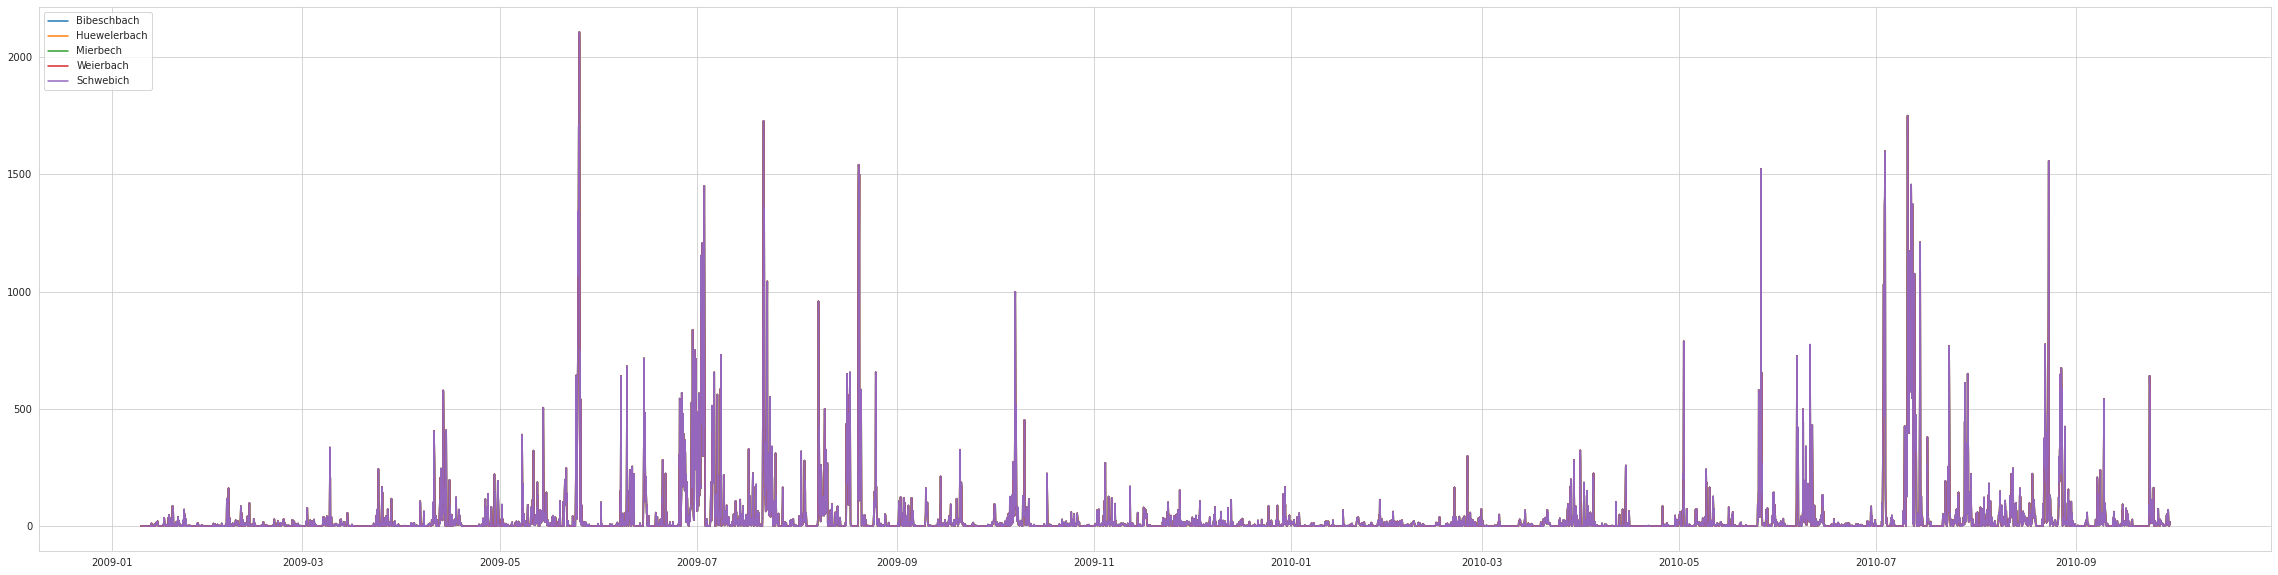

In [6]:
#Visualize ERA 5 data
param = 'cape'
plt.figure(figsize=(40, 10))
plt.plot(Bibeschbach.loc['01-10-2009 00:00:00':'30-09-2010 00:00:00', param] )
plt.plot(Huewelerbach.loc['01-10-2009 00:00:00':'30-09-2010 00:00:00',param])
plt.plot(Mierbech.loc['01-10-2009 00:00:00':'30-09-2010 00:00:00',param])
plt.plot(Weierbach.loc['01-10-2009 00:00:00':'30-09-2010 00:00:00',param])
plt.plot(Schwebich.loc['01-10-2009 00:00:00':'30-09-2010 00:00:00',param])
plt.legend(['Bibeschbach', 'Huewelerbach', 'Mierbech', 'Weierbach', 'Schwebich'], loc='upper left')

Bibeschbach.mean()

bibesch_year = Mierbech.loc['2005-01-01 00:00:00':'2021-12-31 00:00:00', :].resample('Y')
bibesch_year.sum().mean()



In [7]:
ct = Schwebich
feat = 'swvl1'
corr = np.corrcoef(ct['Q_Schwebich'].to_numpy(), ct[feat].to_numpy())
print(corr)

[[1.        0.3322152]
 [0.3322152 1.       ]]


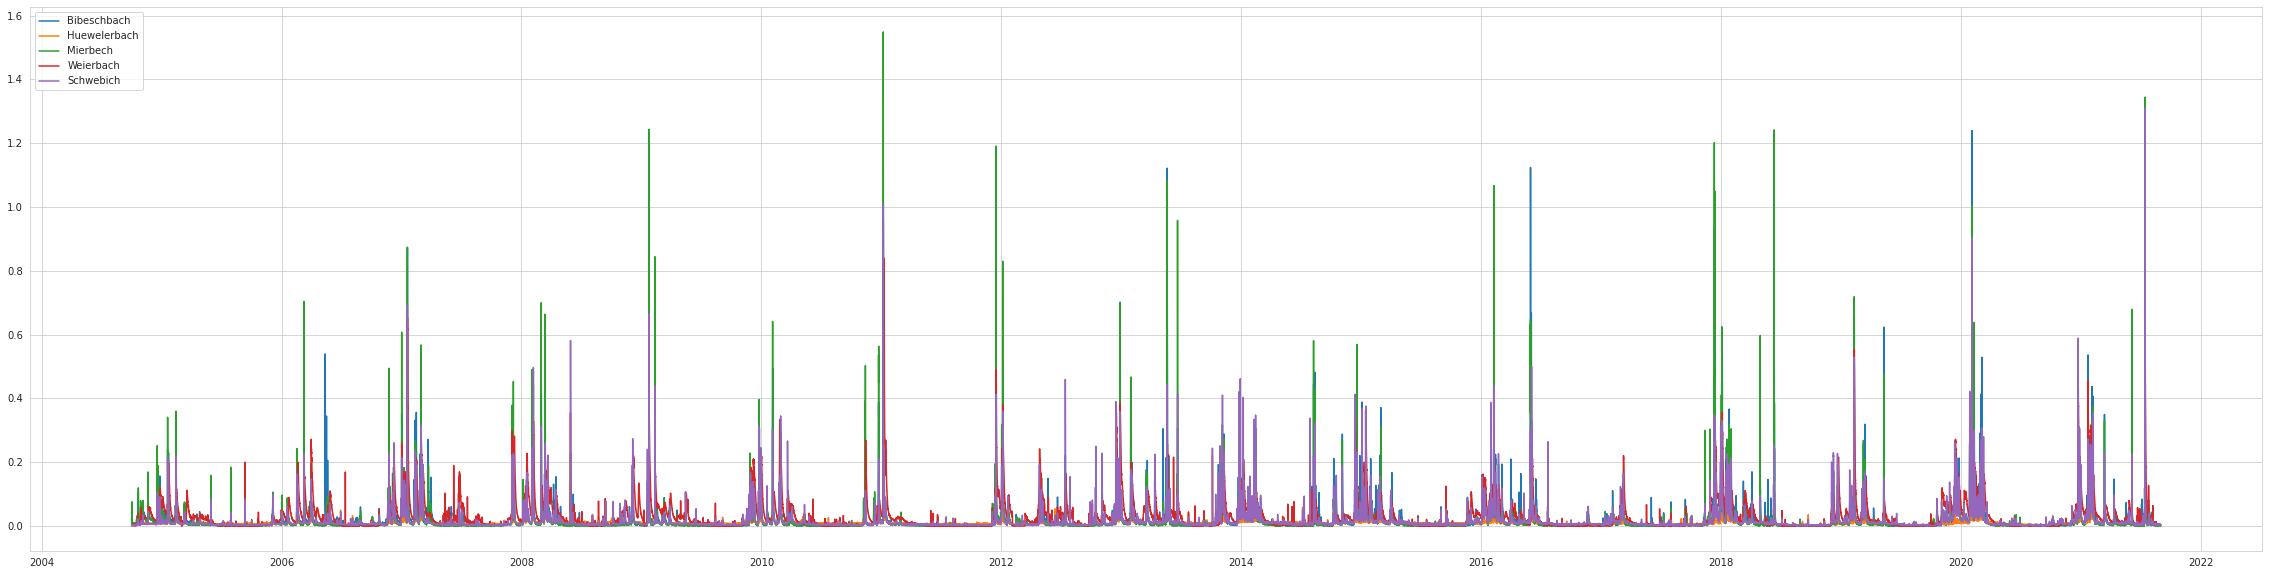

In [8]:

#Visualize runoff
plt.figure(figsize=(40, 10))
plt.plot(Bibeschbach['Q_Bibeschbach'] )
plt.plot(Huewelerbach['Q_Huewelerbach'])
plt.plot(Mierbech['Q_Mierbech'])
plt.plot(Weierbach['Q_Weierbach'])
plt.plot(Schwebich['Q_Schwebich'])
plt.legend(['Bibeschbach', 'Huewelerbach', 'Mierbech', 'Weierbach', 'Schwebich'], loc='upper left')

# Data explanations

https://hess.copernicus.org/preprints/hess-2021-628/

**proxy parameters:**

*1.atmospheric instability:*

| label | explanation                                   | unit   |
|-------|-----------------------------------------------|--------|
|cape   |convective available potential energy          |[J/kg]  |
|cin|convective inhibition|[J/kg]|
|kx|K-Index (George, 1960)| [C°]|
|twcv|total column water vapor|[kg/m^2]|
|q|specific humidity|[kg/kg]|
|rh|relative humidity|[%]|




K-Index = (𝑇850 ℎ𝑃𝑎 − 𝑇500 ℎ𝑃𝑎) + 𝑇𝑑850 ℎ𝑃𝑎 − (𝑇700 ℎ𝑃𝑎 − 𝑇𝑑700 ℎ𝑃𝑎) <br>
The K-Index (George, 1960) is defined via Eq. (1) where T is the air temperature at differing pressure levels and Td the dew point temperature in °C. <br>
it can be generally stated that the higher the K-Index value, the greater the potential for heavy rain. <br>
<br>
*2. moisture content* <br>

| label | explanation                                   | unit   |
|-------|-----------------------------------------------|--------|
|twcv   |total column water vapor                       |[kg/m^2]|
|q|specific humidity|[kg/kg]|
|rh|relative humidity|[%]|

twcv, q and rh relate to a pressure level of 700 hPA and serve as atmospheric moisture content proxies <br>
<br>
*3.storm motion*

| label | explanation                                   | unit   |
|-------|-----------------------------------------------|--------|
|windspeed| square root from squared noth and squared east direction windspeed at 700 hPa| [m/s]|
|LLS| low level wind shear; based on squaree root of differences between wind vectors at ground 100hPa and in 1km height 850hPa| [m/s]|
|DLS| deep-layer wind shear dif. ground and 6km height 500hPa| [m/s]|

The wind shear allows an assessment of the organisational mode of deep moist convection

*4. soil moisture/ catchment wetness*

| label | explanation                                   | unit   |
|-------|-----------------------------------------------|--------|
|swvl1| soil moisturew at 0-7cm|[m³/m³]|
|swvl2| soil moisturew at 7-28cm|[m³/m³]|
|swvl3| soil moisturew at 28-100cm|[m³/m³]|

We considered soil moisture parameters for assessing the pre-event wetness state of a catchment. Therefore, we extracted soil moisture (Swvl) [m3 m-3] at depths of 0-7 cm, 7-28 cm, and 28-100 cm from ERA5, 24 hours before  identified events.


# Hyperparameters

In [9]:
# Define Hyperparameters in dictionary 
# check http://arxiv.org/abs/1206.5533 for a comrehensive overview over the different hyperparameters involved and their impact

model_params = {
  "batch_size": 64,
  "batch_size_e": 512,
  "sequence_length": 512,
  "hidden_size": 256,            # set hidden_size of model i.e. number of nodes per hidden layer
  "num_layer":1,  
  "num_epochs": 5,                # number of training epochs, start high and use the validation dataset after each epoch to check the performance metric 
                                # on an out of batch example, choose the number of epoch with the best validation performance and not the best training
                                # performance
  "drop_out": 0.6,              # set drop_out of model for regularization
  "learning_rate": 0.0005,       # set learning rate which is responsible for how strongly the optimization algorithm adapts the model parameters after
                                # a training epoch
  "loss": torch.nn.MSELoss(),   # set loss function: regression task --> mean squared error, already defined in torch framework, possible to write own
  "set_forget_gate": 3,  
  "adapt_learning_rate_epoch": 1,
  "adapt_gamma_learning_rate": 0.2,
  "adapt_end": 0 ,
  "swa_start": 30,            # start stochastic weight averaging
  "swa_learning_rate": 0.0001,
  "grad_clip" : 'on',            # add gradient clipping
  "max_norm" : 1,                #define max gradient
}

model_params = collections.OrderedDict(model_params)

#Preprocessing

*Catchments*:<br>
'Bibeschbach'<br>
'Huewelerbach'<br>
'Mierbech'<br>
'Weierbach'<br>
'Schwebich'
<br>
<br>
*Experiments*:<br>
A: best model --> 11 features<br>
B: sole meteo model --> only meteorological features<br>
C: all features model<br>


In [10]:
# Define training and testing periods
start_train = '2010-10-01 00:00:00'
#start_train_dt = datetime.datetime.strptime(start_train, '%Y-%m-%d %H:%M:%S')
end_train = '2021-09-30 23:30:00'
start_val = '2009-10-01 00:00:00'
#start_val_dt = datetime.datetime.strptime(start_val, '%Y-%m-%d %H:%M:%S')
end_val = '2010-09-30 23:30:00'
start_test = '2004-10-01 00:00:00'
#start_test_dt = datetime.datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
end_test = '2010-09-30 00:00:00'
#end_test_dt = datetime.datetime.strptime(end_test, '%Y-%m-%d %H:%M:%S')
# Define catchment i.e. the dataframe of interest
catchment = Bibeschbach
catchment_str = 'Bibeschbach'
experiment = 'A'

# Drop excessive features(columns in your dataframe you do not want to use)

excess_name = [col for col in catchment.columns if 'Inter' in col]
catchment.drop(labels=excess_name, axis=1, inplace=True)
catchment.drop(labels=['Q_flag', 'T_flag'], axis=1, inplace=True)
if experiment == 'A':
  catchment.drop(labels=[ 'tcwv','cape', 'cin', 'windspeed', 'DLS', 'swvl4', 'kx', 'EVAP_Roeser', 'rh', ], axis=1, inplace=True)
elif experiment == 'B':
  catchment.drop(labels=['cape', 'cin', 'kx', 'q', 'rh', 'tcwv', 'windspeed', 'LLS', 'DLS', 'swvl1', 'swvl2', 'swvl3', 'swvl4', ], axis = 1, inplace=True)
elif experiment == 'C':
  print('Die deutsche Gesellschaft für Mykologie wählte das Judasohr zum Pilz des Jahres 2017.')
else:
  raise ValueError('No experiment defined')


# Adding additional data (i.e. rainfall) from neighbouring catchments (stations)
#if catchment_str == 'Bibeschbach':
#  neighbouring_catchment_A = Mierbech
#  #neighbouring_catchment_B = Schwebich
#elif catchment_str == 'Huewelerbach':
#  neighbouring_catchment_A = Schwebich
#  neighbouring_catchment_B = Weierbach
#elif catchment_str == 'Mierbech':
#  neighbouring_catchment_A = Bibeschbach
#  #neighbouring_catchment_B = Schwebich
#elif catchment_str == 'Weierbach':
#  neighbouring_catchment_A = Huewelerbach
#  neighbouring_catchment_B = Schwebich
#elif catchment_str == 'Schwebich':
#  neighbouring_catchment_A = Huewelerbach
#  neighbouring_catchment_B = Weierbach
#else:
#  raise ValueError(catchment_str+' not found')

#col_name_A = [col for col in neighbouring_catchment_A.columns if 'P_' in col]
#col_name_B = [col for col in neighbouring_catchment_B.columns if 'P_' in col]
#catchment[str(col_name_A[0])] = neighbouring_catchment_A[col_name_A[0]]
#catchment[str(col_name_A[1])] = neighbouring_catchment_A[col_name_A[1]]
#catchment[str(col_name_B[0])] = neighbouring_catchment_B[col_name_B[0]]
#catchment[str(col_name_B[1])] = neighbouring_catchment_B[col_name_B[1]]

print(catchment_str+' dataset column names '+str(list(catchment)))

# Split and then Standardize the data (z-standartization)
train, val, test = split_data(start_train, end_train, start_val, end_val, start_test, end_test, catchment)
train_scaled, stds, mean = local_standartization(train)
val_scaled = scale(val, stds, mean)
test_scaled = scale(test, stds, mean)

# Save feature column names as string in list
features = list(train_scaled)
# removes target column from feature list
features.remove('Q_'+catchment_str)
# save target column name
target = 'Q_'+catchment_str
# Create datasets including tensors of features and targets
train_set = SequenceDataset(train_scaled, target, features, sequence_length=model_params['sequence_length'])
val_set = SequenceDataset(val_scaled, target, features, sequence_length=model_params['sequence_length'])
test_set = SequenceDataset(test_scaled, target, features, sequence_length=model_params['sequence_length'])

# delete the first int[sequence_length] from datasets

train_set.X = train_set.X[model_params['sequence_length']:, :]
val_set.X = val_set.X[model_params['sequence_length']:, :]
test_set.X = test_set.X[model_params['sequence_length']:, :]
train_set.y = train_set.y[model_params['sequence_length']:, ]
val_set.y = val_set.y[model_params['sequence_length']:, ]
test_set.y = test_set.y[model_params['sequence_length']:, ]

#For reproducibility
def _init_fn(worker_id):
    np.random.seed(int(seed))

# Insert datasets into pytorchs own DataLoader class, which automates the batching of the sammples for later use in the actual model
train_loader = DataLoader(train_set, batch_size = model_params['batch_size'], shuffle = True,  drop_last = True, num_workers=0, worker_init_fn=_init_fn)
val_loader = DataLoader(val_set, batch_size=model_params['batch_size'], shuffle = False, drop_last = True, num_workers=0, worker_init_fn=_init_fn)
test_loader = DataLoader(test_set, batch_size=model_params['batch_size_e'], shuffle = False, drop_last = True, num_workers=0, worker_init_fn=_init_fn)




Bibeschbach dataset column names ['P_Roeser', 'T_Roeser', 'Q_Bibeschbach', 'q', 'LLS', 'swvl1', 'swvl2', 'swvl3']


# Training Ralf 1.1
26.04.22

In [11]:


X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print(X[1, :, :])

Features shape: torch.Size([64, 512, 7])
Target shape: torch.Size([64])
tensor([[ 0.1902, -1.8772, -0.9531,  ...,  0.3736,  0.4887,  0.7209],
        [-0.1371, -1.7756, -0.9274,  ...,  0.3733,  0.4884,  0.7206],
        [-0.1371, -1.6487, -0.9212,  ...,  0.3729,  0.4881,  0.7203],
        ...,
        [-0.1371, -1.3948, -1.3257,  ...,  0.9584,  1.0346,  0.9542],
        [-0.1371, -1.4329, -1.3323,  ...,  0.9543,  1.0317,  0.9550],
        [-0.1371, -1.4456, -1.3389,  ...,  0.9501,  1.0287,  0.9557]],
       device='cuda:0')


In [12]:
len_val = len(val_scaled)-(model_params['sequence_length']+len(val_loader.dataset)-len(val_loader)*model_params['batch_size'])
len_test = len(test_scaled)-(model_params['sequence_length']+len(test_loader.dataset)-len(test_loader)*model_params['batch_size_e'])
obs_val=val_scaled['Q_'+catchment_str].values
obs_val = obs_val[model_params['sequence_length']:(model_params['sequence_length']+len_val)]
obs_test=test_scaled['Q_'+catchment_str].values
obs_test = obs_test[model_params['sequence_length']:(model_params['sequence_length']+len_test)]

In [13]:
len_test

104448

ShallowRegressionLSTM(
  (lstm_1): LSTM(7, 256, batch_first=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (linear): Linear(in_features=256, out_features=1, bias=True)
)
--------------Start training----------------

 
Epoch 1:
Learning rate: 0.0005
batch 2982 of 2982, loss: 0.071278549730777744

MSE:  0.3468661456444444, validation accuracy: NSE = 0.7147328564671573, KGE = [0.46746308]

 
Epoch 2:
Learning rate: 0.0001
batch 2982 of 2982, loss: 0.324754208326339785

MSE:  0.16455767934424848, validation accuracy: NSE = 0.6346375913943751, KGE = [0.78138605]

 
Epoch 3:
Learning rate: 2e-05
batch 2982 of 2982, loss: 0.057557005435228354

MSE:  0.1081652684017921, validation accuracy: NSE = 0.6037821800558925, KGE = [0.80128571]

 
Epoch 4:
Learning rate: 0.0
batch 2982 of 2982, loss: 0.027577165514230728

MSE:  0.09584690728721394, validation accuracy: NSE = 0.6131943485998251, KGE = [0.79793549]

 
Epoch 5:
Learning rate: 0.0
batch 2982 of 2982, loss: 0.028808830305933952

MSE:  0.

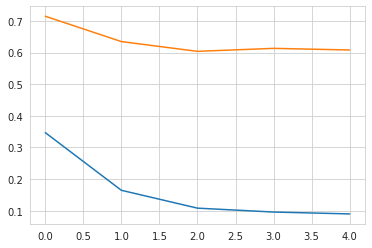

In [14]:
###
# define loss function; Mean Square error
mse_loss_func = torch.nn.MSELoss()

# re-construct model with given hidden size / copy to GPU 
ann_model = ShallowRegressionLSTM(input_size = len(features),
                       hidden_size = model_params["hidden_size"],
                       num_layer=1,
                       drop_out = model_params["drop_out"]
                                 ).to(cuda0)


#from torchvision import models
#from torchsummary import summary
print(ann_model)

# optimizer: Adam, learning rate, weight decay
optimizer = optim.Adam(ann_model.parameters(),
                       lr = model_params["learning_rate"],weight_decay=1e-5 ) #weight_decay=1e-5
    
# define learning rate scheduler / multiple ways to adapt the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size = model_params["adapt_learning_rate_epoch"],
                                      gamma = model_params["adapt_gamma_learning_rate"])

# set forget gate to X to ensure that the model is capable to learn long term dependencies
ann_model.lstm_1.bias_hh_l0.data[model_params['hidden_size']:2 * model_params['hidden_size']] = model_params["set_forget_gate"]
#ann_model.lstm_2.bias_hh_l0.data[model_params['hidden_size']:2 * model_params['hidden_size']] = model_params["set_forget_gate"]

# construct a stochastic weight averaging model
#swa_model = optim.swa_utils.AveragedModel(ann_model)

# Stochastic Weight Averaging
#swa_scheduler = optim.swa_utils.SWALR(optimizer,
#                                      swa_lr = model_params["learning_rate"]) # define swa optimizer

# set model to training
ann_model.train()
train_loss_array = np.array([])
test_acc_array = np.array([])
test_KGE = []
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/Bibeschnew')
print('--------------Start training----------------')
# start training loop over number of epochs
for epoch in range(model_params["num_epochs"]):
    # loop over batches update weights and bias
    loss = 0.0
    batch_num = 0
    print('\n ')
    print('Epoch '+str(epoch+1)+':')
    print('Learning rate: ' + str(round(optimizer.param_groups[0]['lr'], 5)))
    ann_model.train()
    for batch, target in train_loader:
        # initialize weights and hidden state
        y_pred, _   = ann_model(batch) # forward call / unsequeeze adds another dimension which is needed in the LSTM
        #y_pred, h0 , c0 , h1 , c1 = ann_model(batch, h0, c0, h1, c1) # forward call / unsequeeze adds another dimension which is needed in the LSTM
        
        # change dimension / squeeze reduces dimension to 1 / might be unnesarsy if models are setup correct / batch_first=True? /
        train_loss = mse_loss_func(y_pred.flatten(), target)#+0.2*torch.max(torch.square(y_pred.flatten()-target))                            # calulate loss function
        optimizer.zero_grad()                                              # sets gradients of weigths and bias to zero
        train_loss.backward()                                              # computes the gradient of current tensor
        if model_params['grad_clip'] == 'on':
            torch.nn.utils.clip_grad_norm_(ann_model.parameters(), max_norm = model_params['max_norm'])      # gradient clipping
        optimizer.step()                                                   # perform a optimizaiton step
        batch_num+=1
        loss += train_loss.item()
        print(f'batch {batch_num} of {len(train_loader)}, loss: {train_loss}', end='\r')
        
    #if epoch > model_params["swa_start"]:                                                  # epoch >= swa start  
    #    swa_model.update_parameters(ann_model)
    #    swa_scheduler.step()                                               # perform a optimizaiton step swa
    else:
        scheduler.step()
    print('\n')
    ann_model.eval()
    output = np.array([])

    for batch, _ in test_loader:
        y_pred,_  = ann_model(batch) # forward call
        new = y_pred.flatten().cpu().detach().numpy()
        output = np.append(output, new)

    NSE = get_nse(obs_test, output)
    KGE = kge(output, obs_test)
    train_loss_value = loss/len(train_loader)
    train_loss_array = np.append(train_loss_array, train_loss_value)
    test_acc_array = np.append(test_acc_array, NSE)
    test_KGE.append(KGE)
    # print MSE and learning rate after X epochs
    if epoch % 1 == 0:
        #print('Epoch '+str(epoch)+':')
        print(f'MSE:  {loss/len(train_loader)}, validation accuracy: NSE = {NSE}, KGE = {KGE[0]}')
        timestr = time.strftime("%Y%m%d-%H%M%S")
        torch.save(ann_model.state_dict(), timestr+'_'+catchment_str+'_model_'+experiment+'_s'+str(seed)+'_Epoch_'+str(epoch+1))


print('-----------Training complete-------------')
# Update bn statistics for the swa_model
#torch.optim.swa_utils.update_bn(train_loader, swa_model)
print('-----------train loss vs. val NSE--------')
plt.plot(train_loss_array)
plt.plot(test_acc_array)
np.savetxt(timestr+'_'+catchment_str+'_trainloss_'+experiment+'_s'+str(seed), train_loss_array, delimiter=',')
np.savetxt(timestr+'_'+catchment_str+'_testNSE_'+experiment+'_s'+str(seed), test_acc_array, delimiter=',')
df_KGE = pd.DataFrame.from_records(test_KGE)
df_KGE.to_csv(timestr+'_'+catchment_str+'_testKGE_'+experiment+'_s'+str(seed), index=False)

In [15]:
# save model
import csv
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
os.chdir('..')
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/'+str(catchment_str))
torch.save(ann_model.state_dict(), timestr+'_'+catchment_str+'_model_'+experiment+'_s'+str(seed))

#save hyperparameters in csv
hyper_items = model_params.items()
hyper_list=list(hyper_items)

df=pd.DataFrame(hyper_list)

df.to_csv(timestr+'_'+catchment_str+'_hyperparams_'+experiment, index=False)
    
    
ann_model.eval()

output = np.array([])

# save cell state
nCols = model_params['hidden_size']
df_c0 = pd.DataFrame(index=range(0),columns=range(nCols))
#df_c1 = pd.DataFrame(index=range(0),columns=range(nCols))

df_h0 = pd.DataFrame(index=range(0),columns=range(nCols))
#df_h1 = pd.DataFrame(index=range(0),columns=range(nCols))

for batch, _ in test_loader:
        y_pred, (h0, c0) = ann_model(batch) # forward call
        new = y_pred.flatten().cpu().detach().numpy()
        output = np.append(output, new)
        
        # save cell state 0
        c0_new = c0.cpu().detach().numpy()
        ob_c0 = pd.DataFrame(c0_new.reshape(model_params['batch_size_e'], model_params['hidden_size']))
        df_c0 = pd.concat([df_c0, ob_c0], axis=0)
        
        # save cell state 1
        #c1_new = c1.cpu().detach().numpy()
        #ob_c1 = pd.DataFrame(c1_new.reshape(model_params['batch_size'], model_params['hidden_size']))
        #df_c1 = pd.concat([df_c1, ob_c1], axis=0)
        
        # save hidden state 0
        h0_new = h0.cpu().detach().numpy()
        ob_h0 = pd.DataFrame(h0_new.reshape(model_params['batch_size_e'], model_params['hidden_size']))
        df_h0 = pd.concat([df_h0, ob_h0], axis=0)
        
        # save hidden state 
        #h1_new = h1.cpu().detach().numpy()
        #ob_h1 = pd.DataFrame(h1_new.reshape(model_params['batch_size'], model_params['hidden_size']))
        #df_h1 = pd.concat([df_h1, ob_h1], axis=0)       
        
#output_rescaled=(output*stds.loc['Q_'+catchment_str])+mean.loc['Q_'+catchment_str]

df_c0 = df_c0.reset_index(drop=True)
#df_c1 = df_c1.reset_index(drop=True)
df_h0 = df_h0.reset_index(drop=True)
#df_h1 = df_h1.reset_index(drop=True)


np.savetxt(timestr+'_'+catchment_str+'_c0_'+experiment+'_s'+str(seed), df_c0, delimiter=',')
#np.savetxt(timestr+'_'+catchment_str+'_c1_'+experiment, df_c1, delimiter=',')
np.savetxt(timestr+'_'+catchment_str+'_h0_'+experiment+'_s'+str(seed), df_h0, delimiter=',')
#np.savetxt(timestr+'_'+catchment_str+'_h1_'+experiment, df_h1, delimiter=',')

In [16]:
test_KGE
df = pd.DataFrame.from_records(test_KGE)